# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данные находятся в файле /datasets/autos.csv.

__Описание данных__

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

### Подготовка окружения

Загрузим основные библиотеки для выполнения проекта.

In [1]:
!pip install optuna
!pip install catboost

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

import optuna
from sklearn.model_selection import GridSearchCV

import time

Загрузим набор данных, полученных от заказчика

In [3]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('-') # Прямая ссылка на датасет удалена в связи с правилами публикации проектов

## Подготовка данных

### Обзор данных

Выведем на экран пять первых строк данных, обзорную и статистическую информацию по ним.

In [4]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В данных есть пропуски, необходимо изучить долю пропущенных значений и определить варианты их заполнения.

In [5]:
data.isna().sum() / data.shape[0] * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Пропущенные значения составляют до 20% от всего датасета, соответственно отбросить пропуски нецелесообразно. Необходимо найти варианты заполнения пропущенных значений.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные дат хранятся в строковом виде. Однако данные о дате скачивания анкеты из базы, создании анкеты и последней активности пользователя будут недоступны при определении рыночной цены автомобиля, соответственно обучать на них модель нецелесообразно.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Выводы по результатам обзора данных:
- В столбцах с ценой, мощностью двигателя и месяца регистрации присутстсвуют нулевые значения. Это маловероятно, поэтому следует изучить их и определить необходимость их заполнения.
- В столбце с мощностью двигателя также есть экстремальные, невозможные значения, скорее всего вызванные ошибкой внесения данных. Их также необходимо изучить и исправить.
- В столбце в годом регистрации есть значения 1000 и 9999, это невозможно, следовательно необходимо определить точные значения года регистрации для таких наблюдений.
- В столбце с индексом есть четырехзначные числа, что маловероятно, так как большинство индексов пятизначные. Так как правила формирования индекса не российские, где строго зафиксирован шестизначный формат индексов, однозначно сказать, какой принцип лежит в основе формирования индексов, нельзя, поэтому также необходимо отдельно изучить их.
- Столбец с количеством изображений пуст, соответственно его необходимо отбросить.
- В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` есть пропуски, необходимо их изучить и заполнить.

### Подготовка данных

Сперва исправим пропуски в данных.

Заполним пропуски в названии модели. Заполнять будем значением "Unknown", так как определить модель на основании прочих данных не представляется возможным.

In [8]:
data['Model'].fillna('Unknown', inplace=True)

Пропуски в столбце `VehicleType` можно заменить на имеющееся значение типа транспорта для этой модели этого бренда.

In [9]:
model_type = data.pivot_table(index=['Model', 'Brand'], values='VehicleType', aggfunc='first').to_dict()['VehicleType']
model_type = {keys[0]+keys[1]:item for keys, item in model_type.items()}
data['VehicleType'].fillna((data['Model'] + data['Brand']).map(model_type), inplace=True)

Заменим неизвестные значения типа топлива и коробки передач по тому же принципу.

In [10]:
model_fuel = data.pivot_table(index=['Model', 'Brand'], values='FuelType', aggfunc='first').to_dict()['FuelType']
model_fuel = {keys[0]+keys[1]:item for keys, item in model_fuel.items()}
data['FuelType'].fillna((data['Model'] + data['Brand']).map(model_fuel), inplace=True)

In [11]:
model_Gearbox = data.pivot_table(index=['Model', 'Brand'], values='Gearbox', aggfunc='first').to_dict()['Gearbox']
model_Gearbox = {keys[0]+keys[1]:item for keys, item in model_Gearbox.items()}
data['Gearbox'].fillna((data['Model'] + data['Brand']).map(model_Gearbox), inplace=True)

Пропуски в столбце `NotRepaired` можно интерпретировать как отсутствие ремонтных работ с автомобилем.

In [12]:
data['NotRepaired'].fillna('no', inplace=True)

In [13]:
data.isna().sum() / data.shape[0] * 100

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

Изучим значения цены. Построим распределение цены.

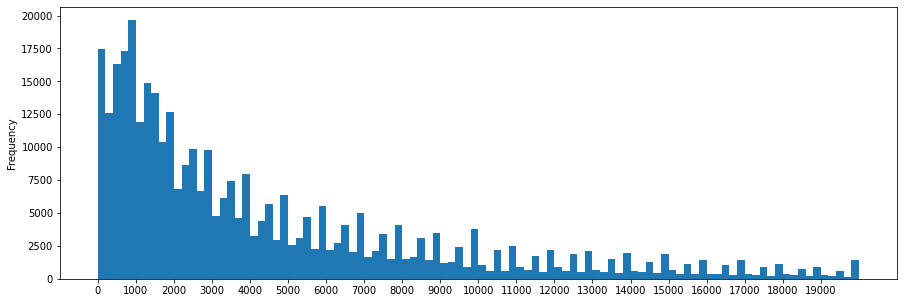

In [14]:
plt.figure(figsize=(15,5))
data['Price'].plot(kind='hist', bins=100)
plt.xticks(range(0,20000,1000))
plt.show()

На графике видно, что есть значительное число предложений до 1000 и даже до 100 евро. Стоимость автомобиля меньше 100 евро маловероятна, поэтому следует отбросить такие наблюдения. Заполнение таких значений невозможно, так как это напрямую повлияет на обучение модели в худшую сторону.

In [15]:
data = data[data['Price']>=100]

Изучим аномальные значения в столбце с мощностью двигателя.

count    341055.000000
mean        111.396197
std         188.373379
min           0.000000
50%         105.000000
95%         218.000000
99%         300.000000
99.9%       606.000000
max       20000.000000
Name: Power, dtype: float64

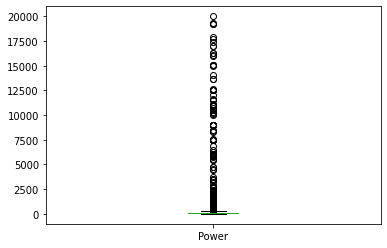

In [16]:
data['Power'].plot(kind='box')
data['Power'].describe(percentiles=(.95,.99,.999))

Самый мощный двигатель легкового автомобиля не превышает 650 лошадиных сил. Вероятнее всего при внесении данных были допущены ошибки, поэтому такие аномально большие значения можно исключить из датасета, учитывая, что они не превышают 0,1% от датасета.

In [17]:
data = data[data['Power']<650]

Изучим нулевые значения в столбце мощности двигателя.

count    340722.000000
mean        107.918635
std          62.804194
min           0.000000
10%           0.000000
11%          44.000000
50%         105.000000
max         645.000000
Name: Power, dtype: float64

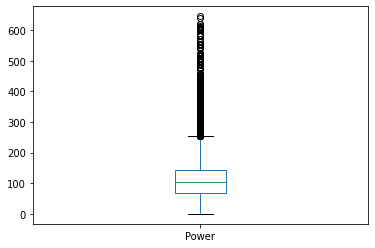

In [18]:
data['Power'].plot(kind='box')
data['Power'].describe(percentiles=(.1,.11))

Нулевые значения составяляют более 10% от датасета.

Мощность двигателя напрямую связана с моделью автомобиля, соответственно можно заполнить нулевые значения средним по модели.

In [19]:
model_power = data.pivot_table(index='Model', values='Power', aggfunc='mean').to_dict()['Power']
data.loc[data['Power']==0,'Power'] = data[data['Power']==0]['Model'].map(model_power)

Проверим наличие нулевых значений.

In [20]:
data.loc[data['Power']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,0.0,serie_1,30000,0,gasoline,land_rover,no,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08


Осталась одна строчка с нулевой мощностью, вероятно это единственная модель этого автомобиля, выставлявшаяся на продажу. Заполним значение мощности средним по году и бренду автомобиля.

In [21]:
model_power = data.pivot_table(index='Brand', columns='RegistrationYear', values='Power', aggfunc='mean').to_dict()[1978]['land_rover']
model_power

71.55741742253261

In [22]:
data.loc[data['Power']==0,'Power'] = model_power

In [23]:
data.loc[data['Power']==0]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


После заполнения в столбце мощности двигателя отсутствуют нулевые значения.

Изучим значения месяца регистрации.

In [24]:
data.pivot_table(index='RegistrationMonth', values='Price', aggfunc='count')

,Price
RegistrationMonth,
0,31591
1,22473
2,20696
3,33666
4,28548
5,28377
6,30691
7,26549
8,22037


Вероятнее всего нулевым значением записан январь при записи месяцев в формате 0-11. Но в таблице также присутствует запись в формате 1-12. Таким образом часть данных смещена, а точно понять, в какой месяц был зарегистрирован тот или иной автомобиль, невозможно. Однако, данные о месяце регистрации вряд ли значительно повлияют на значении цены, поэтому восстановим для 0 значение 1, то есть января.

In [25]:
data['RegistrationMonth'] = data['RegistrationMonth'].replace(0, 1)

Изучим год регистрации.

(1800.0, 2100.0)

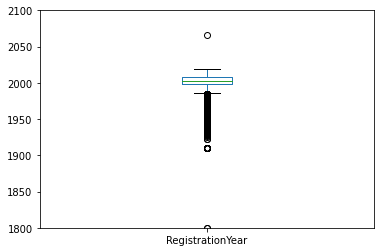

In [26]:
data['RegistrationYear'].plot(kind='box')
plt.ylim(1800,2100)

In [27]:
pd.to_datetime(data['DateCrawled']).describe()

/tmp/ipykernel_508/2326366844.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pd.to_datetime(data['DateCrawled']).describe()


count                  340722
unique                 263505
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Такие значения невозможны, но модель обычно имеет ограниченный срок продажи, что позволяет заполнить год регистрации средним значением для конкретной модели.

При этом автомобиль не может быть выпущен после 2016 года, так как выгрузка данных производилась в 2016 году. Нижний порог установим в 1909 год, так как это дата начала массовой регистрации автомобилей и принятия Международной Конвенции относительно передвижения автомобилей, регламентировавшей необходимость регистрации автомобилей.

Заменим значения для моделей, зарегистрированных позже 2016 года и раньше 1909 года.

In [28]:
model_year = data.pivot_table(index='Model', values='RegistrationYear', aggfunc='mean').to_dict()['RegistrationYear']
data.loc[(data['RegistrationYear']>2016)|
         (data['RegistrationYear']<1909),'RegistrationYear'] = data[(data['RegistrationYear']>2016)|
                                                                    (data['RegistrationYear']<1909)]['Model'].map(model_year)

Проверим, все ли необходимые значения были скорректированы.

<AxesSubplot:>

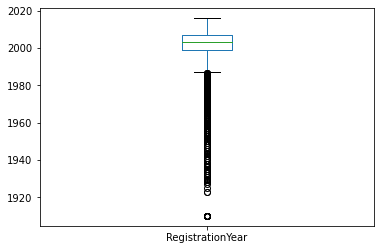

In [29]:
data['RegistrationYear'].plot(kind='box')

Все некорректные значения были заполнены.

Изучим значения индекса.

In [30]:
data['PostalCode'].describe(percentiles=(.01,.049))

count    340722.000000
mean      50700.747213
std       25733.572257
min        1067.000000
1%         2708.000000
4.9%       9619.000000
50%       49525.000000
max       99998.000000
Name: PostalCode, dtype: float64

Около 5% значений индекса указаны некорректно. Так как никакой релевантной информации, которая помогла бы восстановить это значение, нет, будем считать, что при заполнении была пропущена последняя цифра.

В текущем виде для обучения модели индексы не очень подходят, разбиение слишком велико. Однако если укрупнить это значение, взяв только три первые цифры индекса, можно получить распределение продаж автомобилей по укрупненным регионам.

In [31]:
data['PostalCode'] = data['PostalCode'].astype('str').apply(lambda x: x[:3]).astype('int')

Отбросим столбцы с количеством изображений и датами.

In [32]:
data.drop(['NumberOfPictures', 'DateCrawled',  'DateCreated',  'LastSeen'], axis=1, inplace=True)

Проверим, все ли ошибки и неточности в данных устранены.

In [33]:
data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,small,1993.0,manual,96.678293,golf,150000,1,petrol,volkswagen,no,704
1,18300,coupe,2011.0,manual,190.000000,Unknown,125000,5,gasoline,audi,yes,669
2,9800,suv,2004.0,auto,163.000000,grand,125000,8,gasoline,jeep,no,904
3,1500,small,2001.0,manual,75.000000,golf,150000,6,petrol,volkswagen,no,910
4,3600,small,2008.0,manual,69.000000,fabia,90000,7,gasoline,skoda,no,604


In [34]:
data.isna().sum() / data.shape[0] * 100

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
PostalCode           0.0
dtype: float64

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340722 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              340722 non-null  int64  
 1   VehicleType        340722 non-null  object 
 2   RegistrationYear   340722 non-null  float64
 3   Gearbox            340722 non-null  object 
 4   Power              340722 non-null  float64
 5   Model              340722 non-null  object 
 6   Kilometer          340722 non-null  int64  
 7   RegistrationMonth  340722 non-null  int64  
 8   FuelType           340722 non-null  object 
 9   Brand              340722 non-null  object 
 10  NotRepaired        340722 non-null  object 
 11  PostalCode         340722 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 33.8+ MB


In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,340722.0,4590.194810,4515.607789,100.0,1200.0,2900.0,6500.0,20000.0
RegistrationYear,340722.0,2002.697962,6.745673,1910.0,1999.0,2003.0,2007.0,2016.0
Power,340722.0,118.094245,52.747591,1.0,75.0,109.0,143.0,645.0
Kilometer,340722.0,128502.591556,37234.110033,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,340722.0,5.891706,3.552264,1.0,3.0,6.0,9.0,12.0
PostalCode,340722.0,530.616770,242.659623,101.0,327.0,513.0,725.0,999.0


После всех преобразований данные готовы к анализу.

### Изучение данных

Сперва изучим диаграммы рассеяния численных перменных.

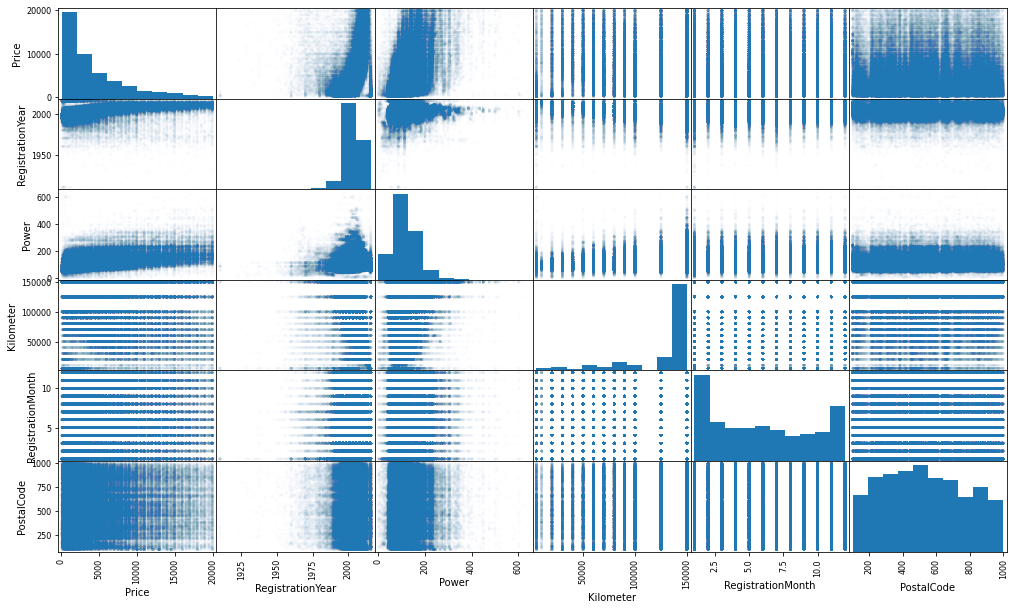

In [37]:
pd.plotting.scatter_matrix(data, alpha=0.01, figsize=(17, 10))
plt.show()

На графике прослеживается линейная зависимость между мощностью автомобиля и ценой, а также экспоненциальная зависимость между годом регистрации автомобиля и ценой.

Также полезно изучить хитмеп и матрицу корреляций между переменными.

<AxesSubplot:>

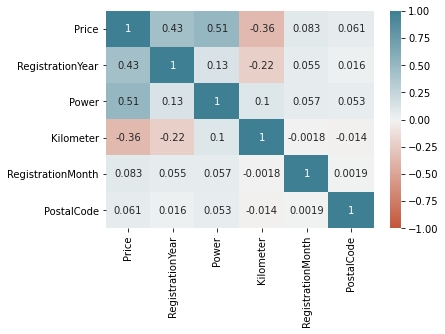

In [38]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=True)

Предварительный вывод подтверждается, наиболее сильная корреляция цены наблюдается с годом регистрации и мощностью автомобиля. Средняя отрицительная корреляция есть между пробегом автомобиля и ценой.

Между прочими переменными корреляция незначительна.

Изучим графики зависимостей между категориальными переменными и ценой.

In [39]:
data['PriceCat'] = pd.cut(data['Price'], bins=range(100, 20001, 3980), include_lowest=False)

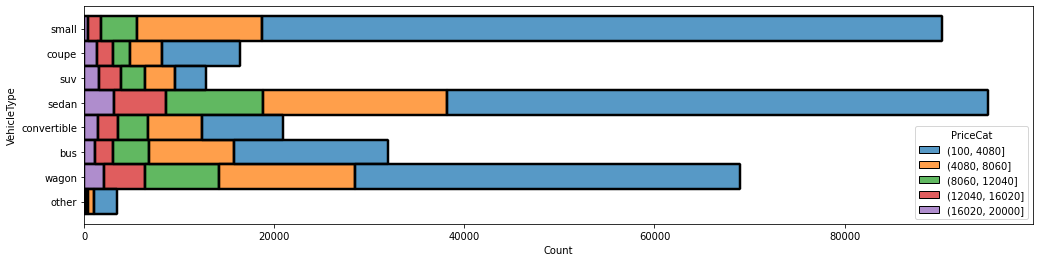

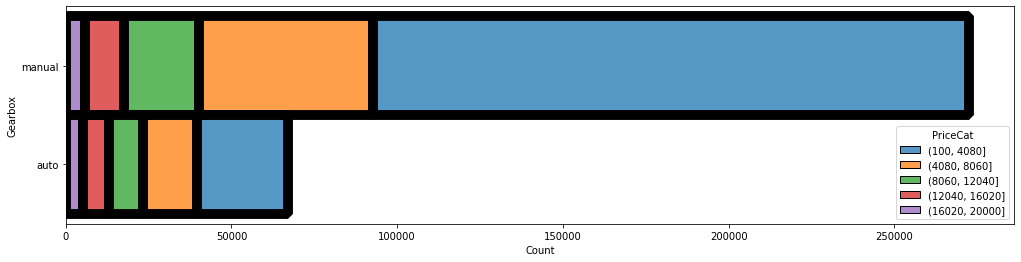

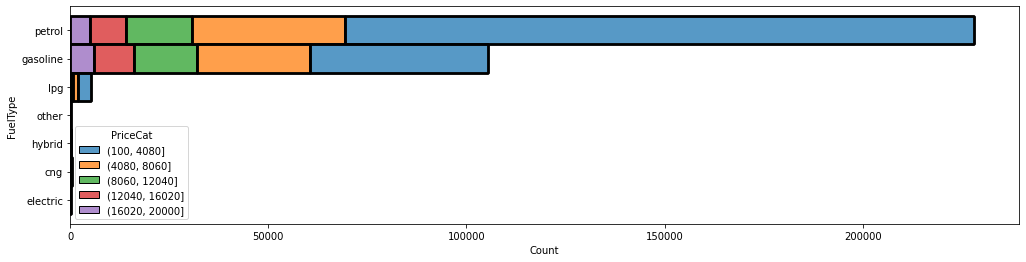

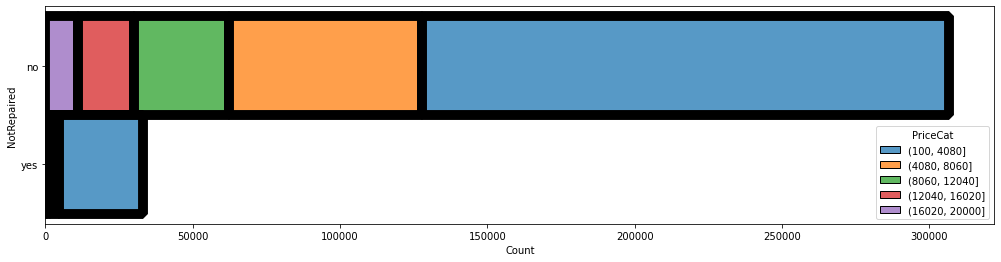

In [40]:
for variable in ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']:
    plt.figure(figsize=(17, 4))
    sns.histplot(data, y=variable, hue='PriceCat', multiple='stack')
    plt.show()

Ценовые группы как правило распределяются равномерно в зависимости от значения категориальных переменных.

### Подготовка данных

Подготовим данные для обучения.

Закодируем данные для обучения всех моделей. Для линейной модели используем метод One Hot Encoder.

In [41]:
linear_data = data.copy()
linear_data = linear_data.drop(['PriceCat'], axis=1)
linear_data = pd.get_dummies(linear_data, drop_first=True)

Для прочих моделей используем метод Ordinal Encoder.

In [42]:
encoder = OrdinalEncoder()
encoded_data = data.copy()
encoded_data[encoded_data.select_dtypes('object').columns] = encoder.fit_transform(encoded_data.select_dtypes('object'))

Разобъем данные на тренировочную и тестовую выборки.

In [43]:
features_train, features_test, target_train, target_test = train_test_split(
    encoded_data.drop(['Price','PriceCat'], axis=1), encoded_data['Price'], test_size=0.25, random_state=12345)

In [44]:
linear_features_train, linear_features_test, linear_target_train, linear_target_test = train_test_split(
    linear_data.drop(['Price'], axis=1), linear_data['Price'], test_size=0.25, random_state=12345)

Масштабируем признаки.

In [45]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## Обучение моделей

### Обучение простых моделей

Обучим первую, простую модель.

In [ ]:
%%time

model = LinearRegression()
model.fit(linear_features_train, linear_target_train)
predictions_train = model.predict(linear_features_train)
predictions_test = model.predict(linear_features_test)
rmse_train = mean_squared_error(linear_target_train, predictions_train) ** .5
rmse_test = mean_squared_error(linear_target_test, predictions_test) ** .5

print(f'Показатель RMSE для линейной регрессии составляет: на тренировочной выборке - {rmse_train}, на тестовой выборке - {rmse_test}')

Линейная регрессия обучалась достаточно долго и показала посредственный результат. Стандартное отклонение цены исходной выборки составляет 4515, соответственно показатель RMSE 2728 незначительно отклоняется от первоначального стандартного отклонения. При этом модель не склонна к переобучению, метрики для тренировочной и тестовой выборки мало различаются.

Напишем простую функцию для упрощения обучения прочих моделей.

In [46]:
def learn(model, features_train, features_test, target_train, target_test):
    model = model
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train)
    predictions_аtest = model.predict(features_test)
    rmse_train = mean_squared_error(target_train, predictions_train) ** .5
    rmse_test = mean_squared_error(target_test, predictions_test) ** .5
    
    print(f'Показатель RMSE для {type(model).__name__} составляет: на тренировочной выборке - {rmse_train}, на тестовой выборке - {rmse_test}')
    

Протестируем модель Catboost.

In [47]:
%%time
learn(CatBoostRegressor(verbose=False, random_state=12345), features_train, features_test, target_train, target_test)

Показатель RMSE для CatBoostRegressor составляет: на тренировочной выборке - 1590.038391392747, на тестовой выборке - 1694.4615782224744
CPU times: user 38 s, sys: 244 ms, total: 38.2 s
Wall time: 1min 54s


Несмотря на кратно большее время обучения, модель с базовыми параметрами показывает существенно лучший результат, чем линейная регрессия.

Протестируем модель LightGBM.

In [48]:
%%time
learn(LGBMRegressor(random_state=12345), features_train, features_test, target_train, target_test)

Показатель RMSE для LGBMRegressor составляет: на тренировочной выборке - 1740.4429743125336, на тестовой выборке - 1798.5073418059799
CPU times: user 4min 15s, sys: 1.16 s, total: 4min 16s
Wall time: 5min 1s


Модель обучилась намного быстрее, но показала результат хуже, чем CatBoost.

Модели CatBoost и LGBM также умеют работать с сырыми данными. Протестируем модели с данными, предварительно не закодированными.

Начнем с модели CatBoost.

In [49]:
raw_data = data.copy()

cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']
raw_data[cat_features] = raw_data[cat_features].astype('category')

raw_features_train, raw_features_test, raw_target_train, raw_target_test = train_test_split(
    raw_data.drop(['Price','PriceCat'], axis=1), raw_data['Price'], test_size=0.25, random_state=12345)

scaler = StandardScaler()
scaler.fit(raw_features_train[raw_features_train.select_dtypes('number').columns])
raw_features_train[raw_features_train.select_dtypes('number').columns] = scaler.transform(raw_features_train[raw_features_train.select_dtypes('number').columns])
raw_features_test[raw_features_test.select_dtypes('number').columns] = scaler.transform(raw_features_test[raw_features_train.select_dtypes('number').columns])

In [50]:
%%time
learn(CatBoostRegressor(verbose=False, cat_features=cat_features, random_state=12345), raw_features_train, raw_features_test, raw_target_train, raw_target_test)

Показатель RMSE для CatBoostRegressor составляет: на тренировочной выборке - 1584.3660658424542, на тестовой выборке - 1682.7302167217
CPU times: user 3min 50s, sys: 818 ms, total: 3min 51s
Wall time: 21min 47s


Качество предсказания на тренировочной и на тестовой выборках практически не изменилось, а вот время обучения выросло кратно.

Попробуем незакодированные данные на модели LGBM.

In [51]:
%%time
model = LGBMRegressor(random_state=12345)
model.fit(raw_features_train, raw_target_train, categorical_feature=cat_features, verbose=False)
predictions_train = model.predict(raw_features_train)
predictions_test = model.predict(raw_features_test)
rmse_train = mean_squared_error(raw_target_train, predictions_train) ** .5
rmse_test = mean_squared_error(raw_target_test, predictions_test) ** .5

print(f'Показатель RMSE для {type(model).__name__} составляет: на тренировочной выборке - {rmse_train}, на тестовой выборке - {rmse_test}')


/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


Показатель RMSE для LGBMRegressor составляет: на тренировочной выборке - 1643.6400826469207, на тестовой выборке - 1717.8209541813055
CPU times: user 7min 16s, sys: 3.88 s, total: 7min 19s
Wall time: 14min 48s


Качество предсказания несколько выросло, в то время как время обучения сильно уменьшилось.

Протестируем дерево решений и случайный лес.

In [52]:
%%time
learn(DecisionTreeRegressor(random_state=12345), features_train, features_test, target_train, target_test)

Показатель RMSE для DecisionTreeRegressor составляет: на тренировочной выборке - 92.55298594268938, на тестовой выборке - 2207.4944743266615
CPU times: user 2.79 s, sys: 39.2 ms, total: 2.83 s
Wall time: 12.1 s


In [ ]:
%%time
learn(RandomForestRegressor(random_state=12345), features_train, features_test, target_train, target_test)

Модели случайного леса и дерева решений намного больше склонны к переобучению. Модель дерева решений показывает существенно худший результат, чем градиентный бустинг на тестовой выборке, случайный лес показывает средний результат.

Протестируем модели с различнысми гиперпараметрами.

### Настройка гиперпараметров с использование GridSearchCV

Начнем с модели CatBoost.

In [ ]:
parameters = {
    'iterations': (800, 1000, 1100),
    'depth': (7,8,9),
    'learning_rate': (0.1, 0.3)
}
grid = GridSearchCV(CatBoostRegressor(verbose=False), param_grid=parameters)
grid.fit(features_train, target_train)

In [ ]:
grid.best_params_

Лучший результат получился при глубине дерева 8, количестве итераций 1100 и коэффициенте обучения 0,3.

In [ ]:
%%time
learn(CatBoostRegressor(depth=8, iterations=1100, learning_rate=0.3, verbose=False, random_state=12345), features_train, features_test, target_train, target_test)

Модель Catboost после настройки гиперпараметров показала чуть лучший результат на тестовой выборке, чем с базовыми параметрами, но переобучилась.

Протестируем модель LGBM с разными гиперпараметрами.

In [ ]:
parameters = {
    'num_iterations': (800, 1000, 1100),
    'max_depth': (7,8,9)
}
grid = GridSearchCV(LGBMRegressor(random_state=12345), param_grid=parameters)
grid.fit(features_train, target_train)

In [ ]:
grid.best_params_

In [ ]:
%%time
learn(LGBMRegressor(random_state=12345,max_depth=8,num_iterations=1100), features_train, features_test, target_train, target_test)

Модель также слегка переобучилась, но показала также лучше результат, в сравнении с обучением без настройки гиперпараметров.

Протестируем модель дерева решений с различными гиперпараметрами. Случайный лес настраивать сложнее, так как он обучается очень долго и дает не лучший результат, поэтому ограничимся деревом решений.

In [ ]:
parameters = {
    'min_samples_split': (2, 15),
    'max_depth': (range(5, 106, 10)),
    'min_samples_leaf': (2, 16),
}
grid = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid=parameters)
grid.fit(features_train, target_train)

In [ ]:
grid.best_params_

In [ ]:
%%time
learn(DecisionTreeRegressor(random_state=12345, max_depth=25, min_samples_leaf=16, min_samples_split=2), features_train, features_test, target_train, target_test)

Модель также переобучилась, но намного меньше, чем при базовых настройках.

### Настройка гиперпараметров с использование optuna

Попробуем оптимизировать параметры с помощью optuna.

Начнем с модели CatBoost.

In [ ]:
def objective_cat(trial):
    params = {'iterations': trial.suggest_int('iterations', 500, 5000),
              'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 1),
              'depth': trial.suggest_int('depth', 1, 15)
             }
    model = CatBoostRegressor(loss_function='RMSE', random_state=12345, verbose=False, **params)
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    
    return mean_squared_error(target_test, predictions_test) ** .5

In [ ]:
study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=5)
study_cat.best_params

И оптимизируем модель LGBM.

In [ ]:
def objective_lgbm(trial):
    params = {'n_estimators': trial.suggest_int('num_iterations', 500, 5000),
              'max_depth': trial.suggest_int('max_depth', 1, 15)
             }
    model = LGBMRegressor(random_state=12345, **params)
    model.fit(features_train, target_train)
    predictions_test = model.predict(features_test)
    
    return mean_squared_error(target_test, predictions_test) ** .5

In [ ]:
study_lgbm = optuna.create_study(direction="minimize")
study_lgbm.optimize(objective_lgbm, n_trials=5)
study_lgbm.best_params

Протестируем модели CatBoost и LGBM с параметрами найденными оптуной.

In [ ]:
%%time
learn(CatBoostRegressor(depth=7, iterations=3792, learning_rate=0.6065370980039926, verbose=False, random_state=12345), features_train, features_test, target_train, target_test)

In [ ]:
%%time
learn(LGBMRegressor(random_state=12345,max_depth=15,num_iterations=819), features_train, features_test, target_train, target_test)

Обучение модели с оптимальными гиперпараметрами проходило дольше, но результаты для модели LGBM оказались лучше, чем при базовых настройках, но хуже, чем при grid оптимизации. Модель Catboost сильно переобучилась и показала результат хуже, чем при базовых настройках.

## Анализ моделей

### Подготовка

Проанализируем модели при различных настройках и сравним ключевые метрики для заказчика - скорость обучения и предсказания и точность предсказания. Напишем функцию, возвращающую разницу времени в формате м/с/mс.

In [ ]:
def exec_time(start, end):
    diff_time = end - start
    diff_time /= 1_000_000
    s, ms = divmod(diff_time, 1_000)
    m, s = divmod(s, 60)
    ms,s,m = int(round(ms, 0)), int(round(s, 0)), int(round(m, 0))
    return f'{m}min {s}s {ms}ms'

Напишем функцию, принимающую на вход модель с параметрами и данные и возвращающую RMSE и время обучения.

In [ ]:
def evaluation(model, features, target):
    start = time.time_ns()
    predictions = model.predict(features)
    end = time.time_ns()
    rmse = mean_squared_error(predictions, target) ** .5
    predict_time = exec_time(start, end)
    return rmse, predict_time

Обучим и протестируем первую модель линейной регрессии для проверки работоспособности написанных функций.

In [ ]:
linear_model = LinearRegression()
start = time.time_ns()
linear_model.fit(linear_features_train, linear_target_train)
end = time.time_ns()
linear_fit_time = exec_time(start, end)
linear_train_rmse, _ = evaluation(linear_model, linear_features_train, linear_target_train)
linear_test_rmse, linear_predict_time = evaluation(linear_model, linear_features_test, linear_target_test)
print(f'Параметры линейной модели:\nВремя обучения: {linear_fit_time}\nВремя предсказания: {linear_predict_time}\nRMSE на обучающей выборке: {linear_train_rmse}\nRMSE на тестовой выборке: {linear_test_rmse}')

Код работает, масштабируем его на проверку всех прочих моделей.

### Сравнение моделей

Протестируем все модели кроме линейной регрессии. Линейная регрессия показывает далеко не лучший результат, при существенных временных затратах на обучение. В процессе тестирования будем замерять время обучения и предсказания, а также метрику RMSE на обучающих и тестовых выборках.

In [ ]:
models = {
    'Дерево решений':DecisionTreeRegressor(random_state=12345),
    'Дерево решений, grid_search':DecisionTreeRegressor(random_state=12345, max_depth=25, min_samples_leaf=16, min_samples_split=2),
    'Случайный лес':RandomForestRegressor(random_state=12345),
    'CatBoost':CatBoostRegressor(verbose=False, random_state=12345),
    'CatBoost, grid_search':CatBoostRegressor(depth=9, iterations=1100, learning_rate=0.3, verbose=False, random_state=12345),
    'CatBoost, optuna':CatBoostRegressor(depth=5, iterations=3733, learning_rate=0.6824141299015694, verbose=False, random_state=12345),
    'LGBM':LGBMRegressor(random_state=12345),
    'LGBM, grid_search':LGBMRegressor(random_state=12345,max_depth=8,num_iterations=1100),
    'LGBM, optuna':LGBMRegressor(random_state=12345,max_depth=13,num_iterations=3968)
}
results = {}

In [ ]:
for model_name, model in models.items():
    start = time.time_ns()
    model.fit(features_train, target_train)
    end = time.time_ns()
    fit_time = exec_time(start, end)
    train_rmse, _ = evaluation(model, features_train, target_train)
    test_rmse, predict_time = evaluation(model, features_test, target_test)
    results[model_name] = [fit_time, predict_time, train_rmse, test_rmse]

Добавим отдельно модели, без предварительного OE кодирования.

In [ ]:
model = CatBoostRegressor(verbose=False, cat_features=cat_features, random_state=12345)
start = time.time_ns()
model.fit(raw_features_train, raw_target_train)
end = time.time_ns()
fit_time = exec_time(start, end)
train_rmse, _ = evaluation(model, raw_features_train, raw_target_train)
test_rmse, predict_time = evaluation(model, raw_features_test, raw_target_test)
results['CatBoost, без OE'] = [fit_time, predict_time, train_rmse, test_rmse]

In [ ]:
model = LGBMRegressor(random_state=12345)
start = time.time_ns()
model.fit(raw_features_train, raw_target_train, categorical_feature=cat_features, verbose=False)
end = time.time_ns()
fit_time = exec_time(start, end)
train_rmse, _ = evaluation(model, raw_features_train, raw_target_train)
test_rmse, predict_time = evaluation(model, raw_features_test, raw_target_test)
results['LGBM, без OE'] = [fit_time, predict_time, train_rmse, test_rmse]

Выведем на экран получившееся сравнение различных моделей.

In [ ]:
(
    pd.DataFrame
    .from_dict(results, orient='index',
               columns=('fit_time', 'predict_time', 'train_rmse', 'test_rmse'))
    .sort_values(by='test_rmse')
)

Наилучшие результаты по качеству предсказания получились с использованием модели LGBM с параметрами depth=13, iterations=3968. Время обучения и предсказания также вполне приемлемы. Однако модель преобучилась и может выдавать нестабильный результат.

Несмотря на то, что эа модель несколько переобучилась, она является лучшей по соотношению всех параметров.

За LGBM следуют три модели: случайного леса, CatBoost и LGBM оптимизированные с помощью GridSearch. Несмотря на то, что модель LGBM переобучилась меньше модели CatBoost и случайного леса, у нее очень высокое время предсказания для условий заказчика. 5 секунд - небольшое время, но в современных условиях, когда пользователи привыкли получать ответ на свои действия от приложения моментально, такое решение вряд ли подойдет. Модель случайного леса сильно переобучилась, из-за чего может выдавать нестабильный результат на реальных данных.

Самый сбалансированный результат показала модель CatBoost с базовыми параметрами. Она не сильно переобучилась и показала конкурентоспособный результат на тестовых данных и достаточно высокую скорость обучения.

Прочие модели показали не лучший результат, поэтому рассматривать их нет смысла.


__Лучшая модель по качеству предсказания - LGBM с параметраии depth=13, iterations=3968.__

__Лучшая модель по соотношению качество/время Catboost с базовыми гиперпараметрами.__

### Вывод

Заказчику рекомендуется обратить внимание на модель CatBoost с базовыми гиперпараметрами. Она показывает наилучший результат и высокое время предсказания и обучения, при этом минимально относительно других моделей переобучаясь.

Для работы приложения это оптимальный выбор, так как в пользовательских интерфейсах необходимо соблюсти баланс между скоростью работы и качеством обучения.

Для лучшей модели также исследуем наиболее важные для предсказания признаки.

In [ ]:
model = CatBoostRegressor(verbose=False, random_state=12345)
model.fit(features_train, target_train)

In [ ]:
model_importances = pd.Series(model.feature_importances_, index=data.drop(['Price', 'PriceCat'], axis=1).columns).sort_values(ascending=False)

model_importances.plot(kind='bar',
                       figsize=(15, 7),
                       title='Feature importances')
plt.ylabel('Mean decrease in impurity')
plt.show()

Ожидаемо наибольшее влияние на цену автомобиля оказывает год его регистрации. Второстепенное значения занимает его мощность, пробег и бренд оказывают еще меньшее, относительно схожее влияние.

Тип транспорта и модель оказывают еще меньшее влиние, а такие показатели как тип топлива, почтовый индекс, коробка передач и месяц регистрации оказывают незначительное влияние на целевую переменную.